# NiftyRegPy Tutorial

This is a simple tutorial on how to use the niftyregpy package

## Installation

In [1]:
%%bash

[ -d /content/niftyreg ] && rm -r /content/niftyreg
git clone https://github.com/KCL-BMEIS/niftyreg/ /content/niftyreg
[ -d "niftyreg" ] && echo "niftyreg was downloaded successfully."

mkdir -p /content/niftyreg/build
cd /content/niftyreg/build
cmake ..
make &> /dev/null
make install &> /dev/null


niftyreg was downloaded successfully.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Found Git
-- Found ZLIB: /usr/lib/x86_64-linux-gnu/libz.so (found version "1.2.11") 
-- Found zlib - the z library will not be built
-- Found libpng - the png library will not be built
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found OpenMP
-- Eigen3 files are copied in /content/niftyreg/buil

Cloning into '/content/niftyreg'...


In [2]:
%pip install --quiet --ignore-installed git+https://github.com/fyrdahl/niftyregpy scikit-image

import niftyregpy as nr
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Simple affine registration

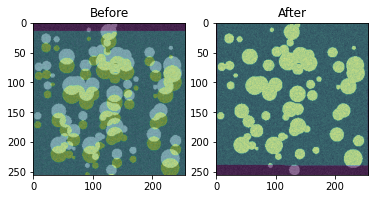

In [124]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add some noise for robustness
img = np.abs(img + np.random.normal(1, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

res = nr.reg.aladin(img, img_shifted, rigOnly=True)

# Plot results
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.imshow(img_shifted, 'viridis', alpha=0.5)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(img, 'gray')
plt.imshow(res[0], 'viridis', alpha=0.5)
plt.title('After')
plt.show()


## Serial affine registrations

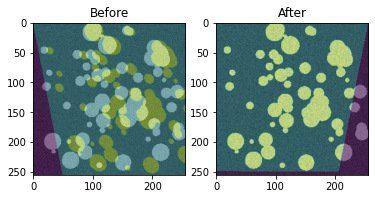

In [123]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add some noise for robustness
img = np.abs(img + np.random.normal(1, 0.1, img.shape))

# Shear the image using skimage
tform_shear = transform.AffineTransform(shear=np.pi/16)
img_sheared = transform.warp(img, tform_shear)

for iter in range(5):
  res = nr.reg.aladin(img, img_sheared, rigOnly=(iter==0), verbose=False)
  img_rot = res[0]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.imshow(img_sheared, 'viridis', alpha=0.5)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(img, 'gray')
plt.imshow(res[0], 'viridis', alpha=0.5)
plt.title('After')
plt.show()
